In [ ]:
# only in colab
!pip install python-igraph
!pip install cairocffi
!pip install matplotlib
!pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24788 sha256=19fd0763076c855b19644512d43b083aa96f3d9612ec67c366e8a2966aa58a70
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [ ]:
import json
import csv
import glob
import pandas as pd
import os
import numpy as np
import networkx as nx
from scipy import io

import igraph as ig
import cairocffi as cairo
import random
import math
import tensorflow
import ast
import itertools
import matplotlib.pyplot as plt
from matplotlib import patches, pyplot
%matplotlib inline

In [ ]:
#!unzip italianTweets_sentiment.zip # RUNNARE SOLO UNA VOLTA SU COLAB

****

#### Use the dataset after sentiment analysis

In [ ]:
df_geolist = pd.read_csv('italianTweets_sentiment.csv')

In [ ]:
#this next step is necessary in order to have hashtag column contain a list of hashtags, not a string
df_geolist['hashtags'] = df_geolist['hashtags'].apply(lambda x: ast.literal_eval(x.lower()))

In [ ]:
# Creo una mappa che assegna i vari valori 0 1 e -1 in base alla opinione mi serve per calcolare la polarity
mymap = {'pro':1, 'neutral':0, 'con':-1}
df_geolist['opinion'] = df_geolist['opinion'].map(lambda s: mymap.get(s) if s in mymap else s) 
# in base a quale delle due versioni di Anna scegliamo cambieremo il nome della colonna

In [ ]:
df_geolist

,Unnamed: 0,tweet_id,created_at,username,location,usermentions,retweet_count,full_text,hashtags,opinion,pos,neg
0,0,860610466590142464,Fri May 05 21:41:39 +0000 2017,140327940,emiliaromagna,['DarioBallini'],0,chiss se autismo calato in modo proporzionale...,"[autismo, morbillo, vaccini]",0,0.012192,0.070409
1,1,867724689698902016,Thu May 25 12:51:02 +0000 2017,556350111,sicilia,['l_gad48'],0,vaccini morbillo autismo graphicnovel forse co...,"[vaccini, morbillo, autismo, graphicnovel]",-1,0.070326,0.484635
2,2,867363895920533504,Wed May 24 12:57:22 +0000 2017,1364930161,sicilia,[],1,vaccini morbillo autismo graphicnovel forse co...,"[vaccini, morbillo, autismo, graphicnovel]",-1,0.070326,0.484635
3,3,864769213046632448,Wed May 17 09:07:01 +0000 2017,824608965464129537,toscana,['MadheaG'],0,la scienza parla. meglio morbillo oggi che aut...,"[scienza, morbillo, autismo, noobbligovaccinal...",0,0.128730,0.140054
4,4,864576616797753345,Tue May 16 20:21:43 +0000 2017,2885743858,toscana,['MadheaG'],0,la scienza parla. meglio morbillo oggi che aut...,"[scienza, morbillo, autismo, noobbligovaccinal...",0,0.128730,0.140054
...,...,...,...,...,...,...,...,...,...,...,...,...
3415,3415,867013188579098624,Tue May 23 13:43:47 +0000 2017,289839081,lazio,"['Marghe_rita63', 'BeaLorenzin']",0,vaccinazione obbligatoria pi che giusta. non ...,[],-1,0.202148,0.496096
3416,3416,878172192596303872,Fri Jun 23 08:45:41 +0000 2017,2858863684,toscana,['citiamo'],0,"vaccinazione obbligatoria, cosa ne pensi? morb...","[morbillo, sondaggi, citiamosondaggi, 23giugno]",-1,0.098466,0.428779
3417,3417,888063868563587073,Thu Jul 20 15:51:40 +0000 2017,886632503041290240,piemonte,['DanielaMondorff'],0,freevax noobbligovaccinale senatore maurizio r...,"[freevax, noobbligovaccinale]",0,0.015137,0.056942
3418,3418,887962592756588544,Thu Jul 20 09:09:14 +0000 2017,367636617,lazio,['DanielaMondorff'],0,freevax noobbligovaccinale senatore maurizio r...,"[freevax, noobbligovaccinale]",0,0.015137,0.056942


In [ ]:
# drop rows for which the column hashtag is empty (COSì ABBIAMO MENO PROBLEMI DOPO)
df_geolist = df_geolist[df_geolist['hashtags'].map(lambda d: len(d)) > 0].reset_index()
df_geolist

,index,Unnamed: 0,tweet_id,created_at,username,location,usermentions,retweet_count,full_text,hashtags,opinion,pos,neg
0,0,0,860610466590142464,Fri May 05 21:41:39 +0000 2017,140327940,emiliaromagna,['DarioBallini'],0,chiss se autismo calato in modo proporzionale...,"[autismo, morbillo, vaccini]",0,0.012192,0.070409
1,1,1,867724689698902016,Thu May 25 12:51:02 +0000 2017,556350111,sicilia,['l_gad48'],0,vaccini morbillo autismo graphicnovel forse co...,"[vaccini, morbillo, autismo, graphicnovel]",-1,0.070326,0.484635
2,2,2,867363895920533504,Wed May 24 12:57:22 +0000 2017,1364930161,sicilia,[],1,vaccini morbillo autismo graphicnovel forse co...,"[vaccini, morbillo, autismo, graphicnovel]",-1,0.070326,0.484635
3,3,3,864769213046632448,Wed May 17 09:07:01 +0000 2017,824608965464129537,toscana,['MadheaG'],0,la scienza parla. meglio morbillo oggi che aut...,"[scienza, morbillo, autismo, noobbligovaccinal...",0,0.128730,0.140054
4,4,4,864576616797753345,Tue May 16 20:21:43 +0000 2017,2885743858,toscana,['MadheaG'],0,la scienza parla. meglio morbillo oggi che aut...,"[scienza, morbillo, autismo, noobbligovaccinal...",0,0.128730,0.140054
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,3411,3411,931445898319626240,Fri Nov 17 08:56:22 +0000 2017,59720254,lombardia,['Mr_Ozymandias'],0,emiliano muore il 23 febbraio 2003. nove giorn...,[mpr],0,0.000014,0.000012
2250,3416,3416,878172192596303872,Fri Jun 23 08:45:41 +0000 2017,2858863684,toscana,['citiamo'],0,"vaccinazione obbligatoria, cosa ne pensi? morb...","[morbillo, sondaggi, citiamosondaggi, 23giugno]",-1,0.098466,0.428779
2251,3417,3417,888063868563587073,Thu Jul 20 15:51:40 +0000 2017,886632503041290240,piemonte,['DanielaMondorff'],0,freevax noobbligovaccinale senatore maurizio r...,"[freevax, noobbligovaccinale]",0,0.015137,0.056942
2252,3418,3418,887962592756588544,Thu Jul 20 09:09:14 +0000 2017,367636617,lazio,['DanielaMondorff'],0,freevax noobbligovaccinale senatore maurizio r...,"[freevax, noobbligovaccinale]",0,0.015137,0.056942


In [ ]:
hashtag_df = pd.DataFrame(columns=['hashtags','pro','neutral','con'])

for _,row in df_geolist.iterrows():
  h_list = row['hashtags']

  for h in h_list:
    if h in str(hashtag_df['hashtags']):
      idx = hashtag_df[hashtag_df['hashtags'] == h].index.values

      if row['opinion']==1:
        hashtag_df.pro[idx] += 1
      elif row['opinion'] == -1:
        hashtag_df.con[idx]+=1
      else:
        hashtag_df.neutral[idx]+=1
    
    else:
      if row['opinion']==1:
        clean_hashtag = [h,1,0,0]
      elif row['opinion'] == -1:
        clean_hashtag = [h,0,0,1]
      else:
        clean_hashtag = [h,0,1,0]
      hashtag_df.loc[len(hashtag_df)]=(clean_hashtag) 

In [ ]:
hashtag_df

,hashtags,pro,neutral,con
0,autismo,0,12,44
1,morbillo,144,564,657
2,vaccini,142,556,496
3,graphicnovel,0,0,6
4,scienza,0,8,4
...,...,...,...,...
2109,sondaggi,0,0,1
2110,citiamosondaggi,0,0,1
2111,23giugno,0,0,1
2112,freevax,0,3,0


In [ ]:
hashtag_df = hashtag_df.groupby('hashtags', as_index=False).sum()
hashtag_df

,hashtags,pro,neutral,con
0,13luglio,0,1,0
1,13ottobre,0,1,0
2,16giugno,3,0,0
3,18luglio,18,0,0
4,18novembre,2,1,0
...,...,...,...,...
470,webeti,0,0,1
471,whatsapp,0,0,7
472,wikivaccini,0,2,0
473,winterishere,0,4,0


In [ ]:
hashtag_df['opinion'] = (hashtag_df['pro']-hashtag_df['con']) / (hashtag_df['pro']+hashtag_df['con']+hashtag_df['neutral'])
hashtag_df

,hashtags,pro,neutral,con,opinion
0,13luglio,0,1,0,0.000000
1,13ottobre,0,1,0,0.000000
2,16giugno,3,0,0,1.000000
3,18luglio,18,0,0,1.000000
4,18novembre,2,1,0,0.666667
...,...,...,...,...,...
470,webeti,0,0,1,-1.000000
471,whatsapp,0,0,7,-1.000000
472,wikivaccini,0,2,0,0.000000
473,winterishere,0,4,0,0.000000


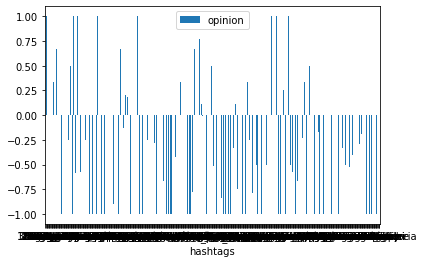

In [ ]:
ax = hashtag_df.plot.bar(x='hashtags', y='opinion', rot=0) i.

# Creation of the network

In [ ]:
adj_dict = {}

for _, tweet in df_geolist.iterrows():
    #first column - user_id/tweet_id/author
    column1 = tweet['username']
    #second column - hashtags
    column2 = tweet['hashtags']
            
    tweet_features = column2          
    
    #create a dictionary of edges
    for feature in tweet_features:
        if column1 in adj_dict.keys():
            if feature in adj_dict[column1]:
                adj_dict[column1][feature] += 1
            else:
                adj_dict[column1][feature] = 1
        else:
            adj_dict[column1] = {}
            adj_dict[column1][feature] = {}
            adj_dict[column1][feature] = 1
            
          
# create a list of edges
edges = []
for key in adj_dict:
    for feature in adj_dict[key]:
        edges.append({'username': key ,'hashtags': feature , 'weight': adj_dict[key][feature]})
#convert to pandas df
edges = pd.DataFrame(edges)
graph = nx.from_pandas_edgelist(edges, 'username', 'hashtags', ['weight'])       

****

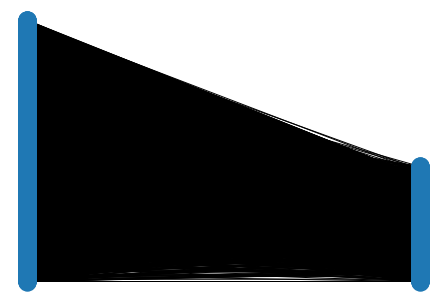

In [ ]:
# print a bipartite graph
components = sorted(nx.connected_components(graph), key=len, reverse=True)
largest_component = components[0]
C = graph.subgraph(largest_component)
X, Y = nx.bipartite.sets(C)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(C, pos=pos)
plt.show()

In [ ]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 1528
Number of edges: 3455
Average degree:   4.5223


In [ ]:
hashtags_nodes = set(hashtag_df['hashtags'])
username_nodes = set(df_geolist['username'])

In [ ]:
G_p = nx.algorithms.bipartite.projection.generic_weighted_projected_graph(graph, username_nodes)
G_h = nx.algorithms.bipartite.projection.generic_weighted_projected_graph(graph, hashtags_nodes)

In [ ]:
G_h.name = f"Graph for hashtag projection"
G_p.name = f"Graph for users projection"

print(nx.info(G_p))
print('\n')
print(nx.info(G_h))

Name: Graph for users projection
Type: Graph
Number of nodes: 1049
Number of edges: 301676
Average degree: 575.1687


Name: Graph for hashtag projection
Type: Graph
Number of nodes: 479
Number of edges: 15611
Average degree:  65.1816


In [ ]:
def print_edge_dist(G):
    edges = nx.to_pandas_edgelist(G)
    weights_df = pd.DataFrame(edges.weight.value_counts().reset_index().values, columns=["weight", "count"])
    weights_df = weights_df.sort_index(axis = 0, ascending=True)
    plt.figure()
    plt.grid(True)
    plt.plot(weights_df['weight'], weights_df['count'], 'ro-')
    plt.xlabel('Weights')
    plt.ylabel('Count')
    plt.title('Weights distribution')
    plt.savefig('weights_dist.png')
    #plt.xlim([10**1,2*10**2])
    plt.show()
    plt.close()

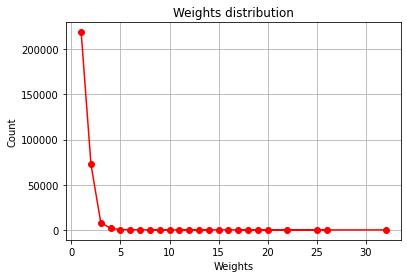

In [ ]:
print_edge_dist(G_p)

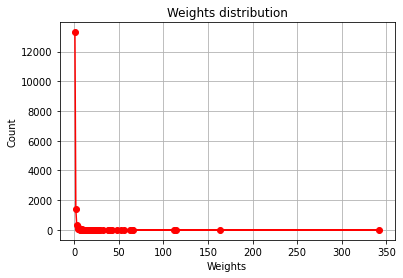

In [ ]:
print_edge_dist(G_h)

In [ ]:
ed = nx.to_pandas_edgelist(G_p)
weights_df = pd.DataFrame(ed.weight.value_counts().reset_index().values, columns=["weight", "count"])
weights_df = weights_df.sort_index(axis = 0, ascending=True)
weights_df

,weight,count
0,1,190338
1,2,64687
2,3,6982
3,4,1510
4,5,305
5,6,218
6,7,54
7,9,42
8,10,32
9,8,26


In [ ]:
def filtered_projection(G, threshold):
    edges = nx.to_pandas_edgelist(G)
    edges = edges.to_dict('records')
    weights = [edge['weight'] for edge in edges]
    filtered_edges = []
    
    for edge  in edges:
        if edge['weight']>threshold:
            filtered_edges.append(edge)
    filtered_edges = pd.DataFrame(filtered_edges)
    if len(filtered_edges)==0:
        print("All the edges would be removed! No edge has been removed.")
    else:
        G = nx.from_pandas_edgelist(filtered_edges,'source', 'target', ['weight'])
    
    return G

In [ ]:
G_p = filtered_projection(G_p,2)
G_h = filtered_projection(G_h,1)

In [ ]:
G_h.name = f"Graph for hashtag projection"
G_p.name = f"Graph for users projection"

print(nx.info(G_p))
print('\n')
print(nx.info(G_h))

Name: Graph for users projection
Type: Graph
Number of nodes: 397
Number of edges: 10620
Average degree:  53.5013


Name: Graph for hashtag projection
Type: Graph
Number of nodes: 206
Number of edges: 2307
Average degree:  22.3981


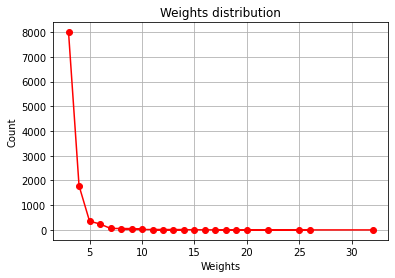

In [ ]:
print_edge_dist(G_p)

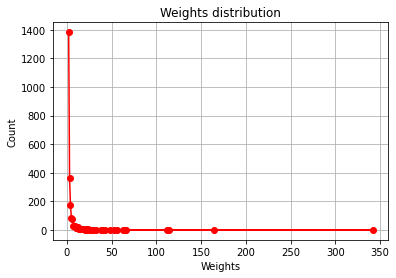

In [ ]:
print_edge_dist(G_h)

In [ ]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.int, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(5, 5)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    return fig

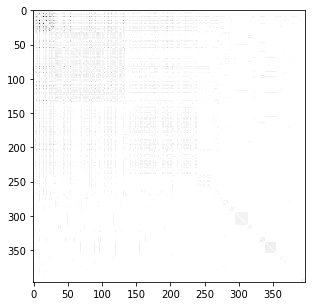

In [ ]:
fig = draw_adjacency_matrix(G_p)
fig.savefig("filterted_users_adj.png")

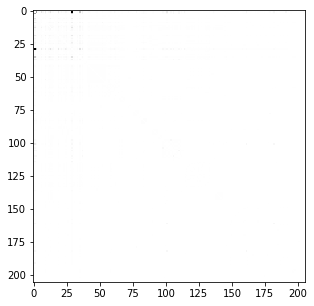

In [ ]:
fig = draw_adjacency_matrix(G_h)
fig.savefig("filtered_hashtags_adj.png")

In [ ]:
# serve per caricare/scaricare grafi
nx.write_adjlist(G_h, "hashtag_projection.adjlist")
# G_h = nx.read_adjlist("hashtag_projection.adjlist")

nx.write_adjlist(G_p,"users_projection.adjlist")
# G_p = nx.read_adjlist("users_projection.adjlist")

In [ ]:
'''
    To have nodes and edges that can be used also in Gephi. I have added a function to deal with nodes' attrbute.
'''
def get_nodes(G):
   
    id_ = list(range(1, len(G.nodes)))
    id_ = pd.Series(id_, dtype = int)
    nodes_graph = pd.Series(list(G.nodes()))   
    nodes = pd.concat([id_, nodes_graph], axis = 1)    
    #GEPHI convention
    nodes.columns=['Id','Label']    
    #remove duplicates
    nodes = nodes.drop_duplicates(subset='Id')   
    return nodes
    
def get_edges(G):
    
    # create the edge list with gephi convention
    edges_list = pd.DataFrame(columns=['Source','Target','Weight'])
    
    edges = list(G.edges(data=True))
    source = []
    target = []
    weight = []
    for i in range(len(edges)):
        source.append(edges[i][0])
        target.append(edges[i][1])
        weight.append(list(edges[i][2].values())[0])
    edges_list['Source'] = source
    edges_list['Target'] = target
    edges_list['Weight'] = weight
                
    return edges_list

nodes_df = df_geolist.groupby('username', as_index=False)['opinion'].mean()
names = pd.Series(nodes_df['username'])
nodes_users = pd.concat([names, nodes_df], axis = 1)
nodes_users.columns=['Id', 'Label', 'Attr']

hash = pd.Series(hashtag_df['hashtags'])
pol = pd.Series(hashtag_df['opinion'])
nodes_hashtags = pd.concat([hash,hash,pol], axis=1)
nodes_hashtags.columns=['Id', 'Label', 'Attr']

In [ ]:
#nodes_h = get_nodes(hashtags_graph)
nodes_hashtags.to_csv("nodes_hashtags_projection.csv", index=False)

edges_h = get_edges(G_h)
edges_h.to_csv("edges_hashtag_projection.csv", index=False)

#nodes_p = user_nodes(df_geolist)
nodes_users.to_csv("nodes_users_projection.csv", index=False)

edges_p = get_edges(G_p)
edges_p.to_csv("edges_users_projection.csv", index=False)

In [ ]:
from analysis_class import NetworkAnalysis

# Hashtag projection

In [ ]:
NetworkAnalysis.get_graph_info(G_h)

Name: Graph for hashtag projection
Type: Graph
Number of nodes: 206
Number of edges: 2307
Average degree:  22.3981


In [ ]:
NetworkAnalysis.graph_density(G_h)

Graph density: 0.10925882074354724


0.10925882074354724

Is the graph connected: no


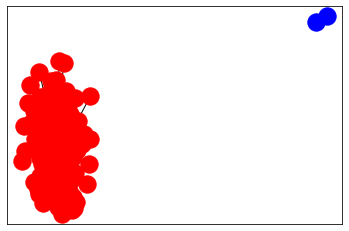

Nodes in the isolated components 2
Nodes in the connected component 204


In [ ]:
NetworkAnalysis.is_connected(G_h)

In [ ]:
NetworkAnalysis.diameter_len(G_h)

Network diameter: 4


4

In [ ]:
NetworkAnalysis.average_path_len(G_h)

Average path length: 1.9360119766262616


1.9360119766262616

In [ ]:
NetworkAnalysis.BFS_SP(G_h, 'liberascelta', 'provax')
print('\n')
NetworkAnalysis.BFS_SP(G_h, 'freevax', 'noobbligovaccinale') #the correct is MovingForward

Shortest path =  liberascelta dallavostraparte provax
Length of the shortest path =  2


Shortest path =  freevax noobbligovaccinale
Length of the shortest path =  1


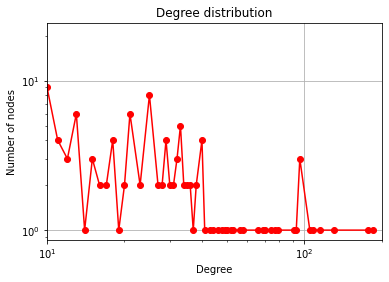

/content/analysis_class.py:142: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])
/content/analysis_class.py:145: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 10**4])


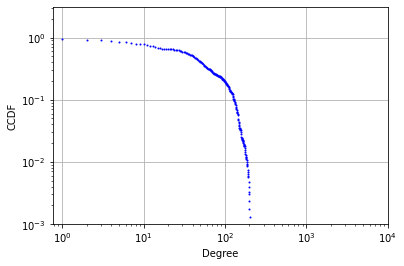

In [ ]:
NetworkAnalysis.plot_degree_dist(G_h)

In [ ]:
NetworkAnalysis.estimate_gamma(G_h)

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2.749860332311571

In [ ]:
pagerank = NetworkAnalysis.page_rank(G_h)
pr = pd.DataFrame(pagerank.items(), columns = ['Hashtag', 'PageRank'])
pr.sort_values(by=['PageRank'], ascending = False, inplace = True) #from highest to smallest
pr[:10]

,Hashtag,PageRank
4,morbillo,0.097825
1,vaccini,0.084499
2,vaccino,0.038393
13,vacciniobbligatori,0.030934
28,novax,0.030410
5,freevax,0.027871
7,iovaccino,0.025645
17,libertadiscelta,0.024387
11,mpr,0.022789
14,noobbligovaccinale,0.022114


# Users projection

In [ ]:
NetworkAnalysis.get_graph_info(G_p)

Name: Graph for users projection
Type: Graph
Number of nodes: 397
Number of edges: 10620
Average degree:  53.5013


In [ ]:
NetworkAnalysis.graph_density(G_p)

Graph density: 0.13510419051980765


0.13510419051980765

Is the graph connected: no


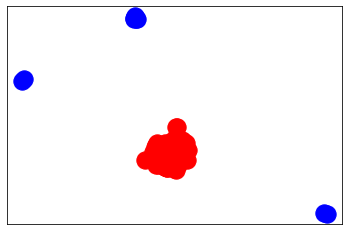

Nodes in the isolated components 10
Nodes in the connected component 387


In [ ]:
NetworkAnalysis.is_connected(G_p)

In [ ]:
NetworkAnalysis.diameter_len(G_p)

Network diameter: 4


4

In [ ]:
NetworkAnalysis.average_path_len(G_p)

Average path length: 2.0460057825132516


2.0460057825132516

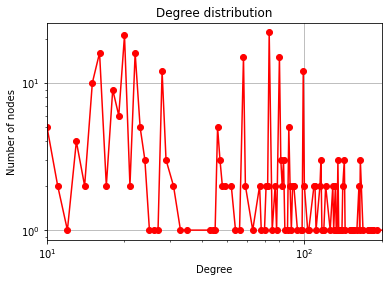

/content/analysis_class.py:142: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])
/content/analysis_class.py:145: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 10**4])


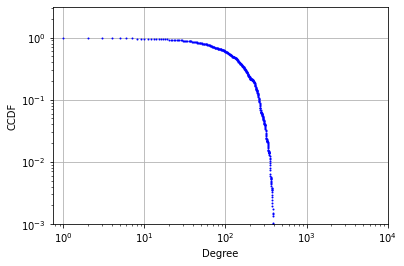

In [ ]:
NetworkAnalysis.plot_degree_dist(G_p)

In [ ]:
NetworkAnalysis.estimate_gamma(G_p)

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


7.60159093204021